## Apple Product Sentiment Analysis

### by Monica Pecha, Sam Choe, and Daniel Fox

### Overview

This project utilized Natural Language Processing (NLP) to understand the sentiment of Apple products from the 2011 SXSW conference in Austin, Texas. 

### Business Understanding

Apple data advisory group - for apple to better understand sentiment of products

### Data Understanding and Limitations
The initial dataset from Twitter contained 9093 rows regarding both Google and Apple products (include dataworld source)

There are three features, (1) the text of the tweet, the product brand (Google, Apple), and the sentiment assigned by people to teh tweet.

Limitations, tweets focused on Apple products in relation to the SXSW conference in 2011 and may not be generalizable across the general popuation or over time. 

Limitations, manual review of tweets after VADER would indicate some misclassification 

### Table of Contents
- Exploratory Data Analysis
    - Synthesizing additional data
    - Implementing VADER
- Preprocessing
- Models
    - Count Vectorization
    - Term Frequency - Inverse Document Frequency (Tfidf) Vectorization
    - Random Forest Classifier
    

### Exploratory Data Analysis (EDA)

In [1]:
# Bringing in packages for EDA, pre-processing, modeling, and visualizations
from collections import defaultdict
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix, recall_score
from collections import Counter

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Reading in the original dataset
df = pd.read_csv("data/judge-1377884607_tweet_product_company.csv", encoding="ISO-8859-1")

In [3]:
df.head(20)

tweet_text  \
0   .@wesley83 I have a 3G iPhone. After 3 hrs twe...   
1   @jessedee Know about @fludapp ? Awesome iPad/i...   
2   @swonderlin Can not wait for #iPad 2 also. The...   
3   @sxsw I hope this year's festival isn't as cra...   
4   @sxtxstate great stuff on Fri #SXSW: Marissa M...   
5   @teachntech00 New iPad Apps For #SpeechTherapy...   
6                                                 NaN   
7   #SXSW is just starting, #CTIA is around the co...   
8   Beautifully smart and simple idea RT @madebyma...   
9   Counting down the days to #sxsw plus strong Ca...   
10  Excited to meet the @samsungmobileus at #sxsw ...   
11  Find &amp; Start Impromptu Parties at #SXSW Wi...   
12  Foursquare ups the game, just in time for #SXS...   
13  Gotta love this #SXSW Google Calendar featurin...   
14  Great #sxsw ipad app from @madebymany: http://...   
15  haha, awesomely rad iPad app by @madebymany ht...   
16  Holler Gram for iPad on the iTunes App Store -...   
17  I just noticed DST is coming this weekend. How...   
18  Just added my #SXSW flights to @planely. Match...   
19  Must have #SXSW app! RT @malbonster: Lovely re...   

    emotion_in_tweet_is_directed_at  \
0                            iPhone   
1                iPad or iPhone App   
2                              iPad   
3                iPad or iPhone App   
4                            Google   
5                               NaN   
6                               NaN   
7                           Android   
8                iPad or iPhone App   
9                             Apple   
10                          Android   
11                      Android App   
12                      Android App   
13  Other Google product or service   
14               iPad or iPhone App   
15               iPad or iPhone App   
16                              NaN   
17                           iPhone   
18               iPad or iPhone App   
19               iPad or iPhone App   

   is_there_an_emotion_directed_at_a_brand_or_product  
0                                    Negative emotion  
1                                    Positive emotion  
2                                    Positive emotion  
3                                    Negative emotion  
4                                    Positive emotion  
5                  No emotion toward brand or product  
6                  No emotion toward brand or product  
7                                    Positive emotion  
8                                    Positive emotion  
9                                    Positive emotion  
10                                   Positive emotion  
11                                   Positive emotion  
12                                   Positive emotion  
13                                   Positive emotion  
14                                   Positive emotion  
15                                   Positive emotion  
16                 No emotion toward brand or product  
17                                   Negative emotion  
18                                   Positive emotion  
19                                   Positive emotion

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df["emotion_in_tweet_is_directed_at"].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [6]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [7]:
df["tweet_text"].iloc[4]

"@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)"

In [8]:
# Defining keywords to diferentiate between Google and Apple product tweets
apple_keywords = ['iPad', 'IPad', 'i-Pad', 'IPAD', 'iphone', 'iPhone', 'Iphone', 'i-phone', 'I-Phone', 'Apple', 'apple', 'Ipad', 'ipad', 'iTunes','Mac', 'IPhone', 'IPHONE']
google_keywords = ['google', 'android', 'Google', 'Android', 'samsung', 'GOOGLE']

def find_brand(text):
    if isinstance(text, str):
        for word in apple_keywords:
            if word in text:
                return "Apple" 
        for word in google_keywords:
            if word in text:
                return "Google" 
    return 'No_Product'

df['product'] = df['tweet_text'].apply(find_brand)

In [9]:
df['product'].value_counts()

Apple         5587
Google        2771
No_Product     735
Name: product, dtype: int64

In [10]:
# Looking for null values in 'product'
df['product'].isna().sum()

0

In [11]:
df['product'].head()

0     Apple
1     Apple
2     Apple
3     Apple
4    Google
Name: product, dtype: object

In [12]:
# Converting strings to integers and combining 'neutral'/'no emotion toward brand or product' with 'unknown'/'I can't tell'
# 0 = negative, 1 = neutral, and 2 = positive
# Renaming 'is_there_an_emotion_directed_at_a_brand_or_product' to 'emotion'
mapping = {"Positive emotion": 2, "No emotion toward brand or product": 1, "I can't tell": 1, "Negative emotion": 0}
df['emotion'] = df["is_there_an_emotion_directed_at_a_brand_or_product"].map(mapping)

In [13]:
df["emotion"].value_counts()

1    5545
2    2978
0     570
Name: emotion, dtype: int64

In [14]:
#use 1 to show all info in cell below then comment it out and use 2 to go back to default view
#1
#pd.set_option('display.max_rows', None)
#pd.set_option('display.max_colwidth', None)

#2
pd.reset_option('display.max_rows')
pd.reset_option('display.max_colwidth')

In [15]:
#exploring 'No_Product' tweets
filtered_df = df[df['product'] == 'No_Product']

print(filtered_df['tweet_text'])

6                                                                                                                                                                  NaN
51                                    ÛÏ@mention {link} &lt;-- HELP ME FORWARD THIS DOC to all Anonymous accounts, techies,&amp; ppl who can help us JAM #libya #SXSW
52                                                                                     ÷¼ WHAT? ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter
53                                                                        .@mention @mention on the location-based 'fast, fun and future' - {link} (via @mention #sxsw
65                       Agree. RT @mention Wait. FIONA APPLE is in town??? Somebody kidnap her and put her in a recording studio until she records a new album. #sxsw
66                                                                            At #sxsw? @mention / @mention wanna buy you a drink. 7pm at Fado on 4th. {link} Join us

In [18]:
df2 = df[["tweet_text", "product", "emotion"]]

In [21]:
# Creating an Apple product only dataframe
df2_apple = df2[df2['product'] == "Apple"]

In [22]:
df2_apple.head()

tweet_text  \
0               .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1   @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                               @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                            @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
5  @teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd   

  product  emotion  
0   Apple        0  
1   Apple        2  
2   Apple        2  
3   Apple        0  
5   Apple        1

In [23]:
df2_apple.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5587 entries, 0 to 9091
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  5587 non-null   object
 1   product     5587 non-null   object
 2   emotion     5587 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 174.6+ KB


In [24]:
# The emotion in the dataset in not balanced
df2_apple["emotion"].value_counts(normalize=True)

1    0.540720
2    0.383748
0    0.075532
Name: emotion, dtype: float64

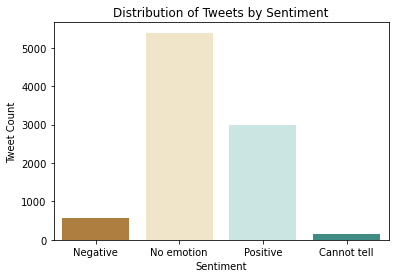

In [155]:
import seaborn as sns

#For the entire dataset
fig, ax = plt.subplots()

classes = ['Negative emotion', 'No emotion toward brand or product', 'Positive emotion', "I can't tell"]
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df, palette='BrBG', order=classes)

ax.set(xticklabels=['Negative', 'No emotion', 'Positive', 'Cannot tell'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('data/fig0.png', dpi=200, transparent=True)
plt.show()

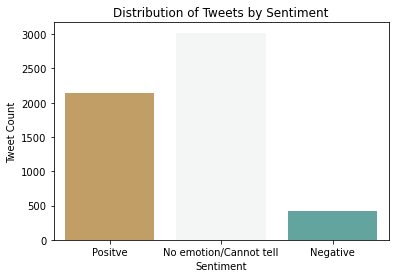

In [158]:
#For Apple Products only
fig, ax = plt.subplots()

classes = [2, 1, 0]
sns.countplot(x='emotion', data=df2_apple, palette='BrBG', order=classes)

ax.set(xticklabels=['Positve', 'No emotion/Cannot tell', 'Negative'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('data/fig0.png', dpi=200, transparent=True)
plt.show()


<p> To address the "emotion" feature class inbalance we attempted to scrape down tweets from Twitter about Apple products with negative sentiment. The code for this process can be found in the Twitter_scraping_template notebook found in the GitHub repo ____. The scraping was unsuccessful due to access issues:<p>

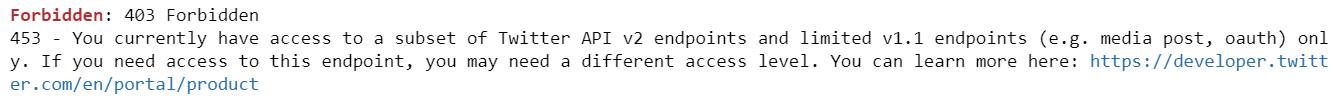

In [25]:
# In order to address the class imbalance we generated tweets with negative sentiment regarding Apple products using ChatGPT
df_new_tweets = pd.read_excel("data/Tweets_SyntheticGeneration_20240503.xlsx")

In [26]:
# The new ChatGPT tweets
df_new_tweets

Unnamed: 0  \
0                                                                                                                    1. "Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed"   
1                                                                                                            1. "Just got the new iPhone, and it's already crashing apps left and right. Seriously, Apple, get your act together! #frustrated"   
2                                1. "Just tried out the original iPhone... what a disappointment! The touch screen is so unresponsive, and the camera quality is terrible. Can't believe people actually bought into this hype. #iPhone #fail"   
3                                                                                                     1. "Just tried the iPad 2 at #SXSW... disappointed doesn't even begin to describe it. Same old design, same old issues. #iPad2 #letdown"   
4                           1. "The iPod Nano 3rd Generation was a disappointment. Sure, it had video playback, but the lack of camera and the square design made it awkward to use, and the battery life was poor. #iPodNano3 #disappointing"   
5                                                                                  1. "The Power Mac G4 Cube may look cool, but it's loud, slow, and prone to overheating. Definitely not worth the investment. #PowerMacG4Cube #disappointed"   
6                                                                                                                                            1. Just got the latest iPhone, and it's already slower than my old one. Thanks, Apple. #SlowPhone   
7                                                                                                               1. Just had my daily dose of frustration trying to connect my iPhone to my MacBook. Can these devices not communicate or what?   
8                                                                                                      1. Just when I thought my MacBook couldn't get any slower, it decides to take a coffee break every time I open an app. #MacBookMeltdown   
9                                                                             1. Just when I thought my MacBook keyboard couldn't get any worse, it decides to malfunction on a deadline day. Thanks for the stress, Apple. #KeyboardNightmare   
10                                                                                                                           10. "Another day, another software update that ruins my iPhone's performance. When will Apple learn? #frustrated"   
11                                                                                                             10. "Just tried the Magic Mouse... what a disappointment. Uncomfortable, imprecise, and overpriced. #MagicMouse #letdown #SXSW"   
12                                                                                                                  10. "The iPhone 4's antenna issues were a major flaw. Drop a call just by holding it? Seriously, Apple? #iPhone4 #letdown"   
13                        10. "The iPod Nano 6th Generation was a letdown. Sure, it had a touchscreen, but the lack of storage options and the square design made it awkward to use, and the battery life was poor. #iPodNano6 #disappointing"   
14                                                                                        10. "The price of Apple products keeps going up, but the quality seems to be going down. Starting to rethink my loyalty. #overpriced #appleproducts"   
15                                                                                                                                                                         10. AirPods case: the Bermuda Triangle of accessories. #CaseMystery   
16                                                                                                                

In [27]:
df_new_tweets.columns = ['tweet_text', 'extra_col']

In [28]:
# ChatGPT generated several duplicate tweets that we then removed from the dataset
df_new_tweets_clean = df_new_tweets.drop_duplicates(subset='tweet_text')

In [29]:
df_new_tweets_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1719 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  1719 non-null   object
 1   extra_col   1 non-null      object
dtypes: object(2)
memory usage: 40.3+ KB


In [30]:
df_new_tweets_clean['product'] = 'Apple'

<ipython-input-30-55661c2f5466>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['product'] = 'Apple'


In [31]:
df_new_tweets_clean.head()

tweet_text  \
0                                                                                           1. "Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed"   
1                                                                                   1. "Just got the new iPhone, and it's already crashing apps left and right. Seriously, Apple, get your act together! #frustrated"   
2       1. "Just tried out the original iPhone... what a disappointment! The touch screen is so unresponsive, and the camera quality is terrible. Can't believe people actually bought into this hype. #iPhone #fail"   
3                                                                            1. "Just tried the iPad 2 at #SXSW... disappointed doesn't even begin to describe it. Same old design, same old issues. #iPad2 #letdown"   
4  1. "The iPod Nano 3rd Generation was a disappointment. Sure, it had video playback, but the lack of camera and the square design made it awkward to use, and the battery life was poor. #iPodNano3 #disappointing"   

                                                                                                                 extra_col  \
0   "Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed"   
1                                                                                                                      NaN   
2                                                                                                                      NaN   
3                                                                                                                      NaN   
4                                                                                                                      NaN   

  product  
0   Apple  
1   Apple  
2   Apple  
3   Apple  
4   Apple

In [32]:
import re # importing regular expressions

In [33]:
# Define a regular expression pattern to match any number followed by a period and a space
pattern = r'^\d+\.\s'

In [34]:
# Need to remove the numbers in front of the tweets
df_new_tweets_clean['tweet_text'][3]

'1. "Just tried the iPad 2 at #SXSW... disappointed doesn\'t even begin to describe it. Same old design, same old issues. #iPad2 #letdown"'

In [35]:
# Iterate through the dataframe column and remove the matching pattern using regex
df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))

<ipython-input-35-4be8770b532e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_tweets_clean['tweet_text'] = df_new_tweets_clean['tweet_text'].map(lambda x: re.sub(pattern, '', x))


In [36]:
df_new_tweets_clean.head()

tweet_text  \
0                                                                                           "Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed"   
1                                                                                   "Just got the new iPhone, and it's already crashing apps left and right. Seriously, Apple, get your act together! #frustrated"   
2       "Just tried out the original iPhone... what a disappointment! The touch screen is so unresponsive, and the camera quality is terrible. Can't believe people actually bought into this hype. #iPhone #fail"   
3                                                                            "Just tried the iPad 2 at #SXSW... disappointed doesn't even begin to describe it. Same old design, same old issues. #iPad2 #letdown"   
4  "The iPod Nano 3rd Generation was a disappointment. Sure, it had video playback, but the lack of camera and the square design made it awkward to use, and the battery life was poor. #iPodNano3 #disappointing"   

                                                                                                                 extra_col  \
0   "Bought the latest iPhone, and it's already glitching. Apple, you really need to get your act together! #disappointed"   
1                                                                                                                      NaN   
2                                                                                                                      NaN   
3                                                                                                                      NaN   
4                                                                                                                      NaN   

  product  
0   Apple  
1   Apple  
2   Apple  
3   Apple  
4   Apple

In [37]:
df2_apple.head()

tweet_text  \
0               .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1   @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                               @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                            @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
5  @teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd   

  product  emotion  
0   Apple        0  
1   Apple        2  
2   Apple        2  
3   Apple        0  
5   Apple        1

In [38]:
df_combo = pd.concat([df2_apple, df_new_tweets_clean], axis=0)

In [39]:
columns_to_drop = ['extra_col', 'emotion']
df_combo.drop(columns=columns_to_drop, inplace=True)

In [40]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweet_text  7306 non-null   object
 1   product     7306 non-null   object
dtypes: object(2)
memory usage: 171.2+ KB


Implementing VADER on the emotion column

In [41]:
#!pip install vaderSentiment

In [42]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

# Initialize VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Assuming df is your DataFrame with tweet texts
# Example:
# df = pd.DataFrame({'tweet_text': ["I love this place!", "This movie is terrible.", "Feeling neutral about this weather."]})

# Drop NaN values or replace with empty strings (MP-do we need this?)
df_combo['tweet_text'].fillna('', inplace=True)

# Analyze sentiment for each tweet and add the scores to the DataFrame
df_combo['sentiment'] = df_combo['tweet_text'].apply(lambda tweet: analyzer.polarity_scores(tweet))

# Extract compound sentiment score from the sentiment dictionary
df_combo['compound_score'] = df_combo['sentiment'].apply(lambda score_dict: score_dict['compound'])

# Function to categorize compound score into positive, negative, or neutral
def categorize_sentiment(score):
    if score > 0.05:
        return '2'
    elif score < -0.05:
        return '0'
    else:
        return '1'

# Apply the function to create a new column with sentiment category
df_combo['emotion'] = df_combo['compound_score'].apply(categorize_sentiment)

# Print or use the DataFrame as per your requirement
print(df_combo[['tweet_text', 'compound_score', 'emotion']])

                                                                                                                                                                                                                                 tweet_text  \
0                                                                                                           .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1                                                                                               @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                                                                                                                           @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                           

In [43]:
df_combo.head()

tweet_text  \
0               .@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.   
1   @jessedee Know about @fludapp ? Awesome iPad/iPhone app that you'll likely appreciate for its design. Also, they're giving free Ts at #SXSW   
2                                                               @swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.   
3                                                            @sxsw I hope this year's festival isn't as crashy as this year's iPhone app. #sxsw   
5  @teachntech00 New iPad Apps For #SpeechTherapy And Communication Are Showcased At The #SXSW Conference http://ht.ly/49n4M #iear #edchat #asd   

  product                                                     sentiment  \
0   Apple   {'neg': 0.173, 'neu': 0.827, 'pos': 0.0, 'compound': -0.68}   
1   Apple      {'neg': 0.0, 'neu': 0.59, 'pos': 0.41, 'compound': 0.91}   
2   Apple         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}   
3   Apple  {'neg': 0.0, 'neu': 0.681, 'pos': 0.319, 'compound': 0.7269}   
5   Apple         {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}   

   compound_score emotion  
0         -0.6800       0  
1          0.9100       2  
2          0.0000       1  
3          0.7269       2  
5          0.0000       1

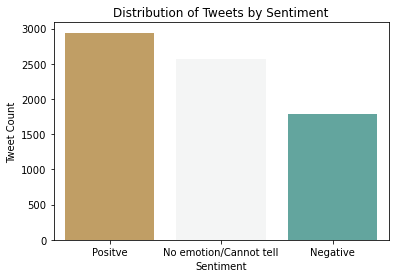

In [159]:
#For Apple Products only - VADER
fig, ax = plt.subplots()

classes = [2, 1, 0]
sns.countplot(x='emotion', data=df_combo, palette='BrBG', order=classes)

ax.set(xticklabels=['Positve', 'No emotion/Cannot tell', 'Negative'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('data/fig0.png', dpi=200, transparent=True)
plt.show()

In [44]:
df_combo["emotion"].value_counts()

2    2942
1    2571
0    1793
Name: emotion, dtype: int64

In [45]:
df_combo['emotion']=df_combo['emotion'].astype(np.int64)

In [46]:
df_combo.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7306 entries, 0 to 1767
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      7306 non-null   object 
 1   product         7306 non-null   object 
 2   sentiment       7306 non-null   object 
 3   compound_score  7306 non-null   float64
 4   emotion         7306 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 342.5+ KB


In [47]:
df_combo_neg_sample = df_combo[df_combo['emotion'] == 0].sample(n=1500)
df_combo_neutral_sample = df_combo[df_combo['emotion'] == 1].sample(n=1500)
df_combo_pos_sample = df_combo[df_combo['emotion'] == 2].sample(n=1500)

In [48]:
df_combo_neg_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1500 entries, 1862 to 8259
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      1500 non-null   object 
 1   product         1500 non-null   object 
 2   sentiment       1500 non-null   object 
 3   compound_score  1500 non-null   float64
 4   emotion         1500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 70.3+ KB


In [49]:
df_combo_neg_sample['emotion'].value_counts()

0    1500
Name: emotion, dtype: int64

In [50]:
df_combo_sample = pd.concat([df_combo_neg_sample, df_combo_neutral_sample, df_combo_pos_sample], axis=0)

In [51]:
df_combo_sample.head()

tweet_text  \
1862                                     @mention about to talk at #sxsw on mistakes building #Netflix #iphone app   
117   "Thought the iPod Touch would be a gaming powerhouse, but it's just average. #iPodTouch #disappointed #SXSW"   
957            "The iPad 2 is a disappointment. Expected more from Apple's flagship tablet. #iPad2 #letdown #SXSW"   
4712                                There is nothing sillier than watching people record video with an ipad. #SXSW   
945             "Tried the MacBook... heavy, outdated, and not worth the investment. #MacBook #disappointed #SXSW"   

     product                                                        sentiment  \
1862   Apple    {'neg': 0.185, 'neu': 0.815, 'pos': 0.0, 'compound': -0.3612}   
117    Apple     {'neg': 0.217, 'neu': 0.783, 'pos': 0.0, 'compound': -0.631}   
957    Apple  {'neg': 0.184, 'neu': 0.724, 'pos': 0.093, 'compound': -0.3892}   
4712   Apple    {'neg': 0.127, 'neu': 0.873, 'pos': 0.0, 'compound': -0.1877}   
945    Apple    {'neg': 0.302, 'neu': 0.698, 'pos': 0.0, 'compound': -0.5812}   

      compound_score  emotion  
1862         -0.3612        0  
117          -0.6310        0  
957          -0.3892        0  
4712         -0.1877        0  
945          -0.5812        0

In [52]:
df_combo_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4500 entries, 1862 to 5971
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   tweet_text      4500 non-null   object 
 1   product         4500 non-null   object 
 2   sentiment       4500 non-null   object 
 3   compound_score  4500 non-null   float64
 4   emotion         4500 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 210.9+ KB


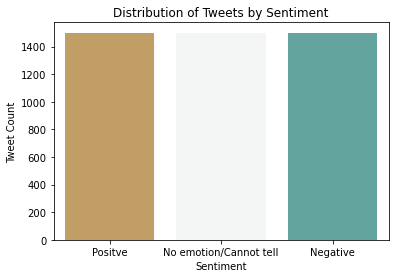

In [160]:
#For Apple Products only
fig, ax = plt.subplots()

classes = [2, 1, 0]
sns.countplot(x='emotion', data=df_combo_sample, palette='BrBG', order=classes)

ax.set(xticklabels=['Positve', 'No emotion/Cannot tell', 'Negative'], 
       xlabel='Sentiment', ylabel='Tweet Count', title='Distribution of Tweets by Sentiment')

plt.savefig('data/fig0.png', dpi=200, transparent=True)
plt.show()

In [53]:
df_combo_sample['emotion'].value_counts(normalize=True)

2    0.333333
1    0.333333
0    0.333333
Name: emotion, dtype: float64

In [54]:
columns_to_drop = ['sentiment', 'compound_score', 'product']
df_combo_sample.drop(columns=columns_to_drop, inplace=True)

## Word Frequencies by Emotion 

### Positive

In [149]:
#df_combo_pos_sample.drop(columns=columns_to_drop, inplace=True)

In [136]:
# Defining X and y
X=df_combo_pos_sample["tweet_text"]
y=df_combo_pos_sample["emotion"]

In [137]:
sw = stopwords.words('english')

In [138]:
# Adding stopwords based on the dataset
sw.extend(["sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [139]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [140]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [141]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [161]:
#token_tweets

In [143]:
cv=CountVectorizer()

In [144]:
X_vec_pos = cv.fit_transform(token_tweets)
X_vec_pos = pd.DataFrame.sparse.from_spmatrix(X_vec_pos)
X_vec_pos.columns = sorted(cv.vocabulary_)
X_vec_pos.set_index(y.index, inplace=True)

In [125]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [162]:
from collections import Counter

# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies = X_vec_pos.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(50)

# Print the most common words and their frequencies
print(most_common_words)

        Frequency
Word             
ipad          734
apple         544
iphone        455
store         216
quot          188


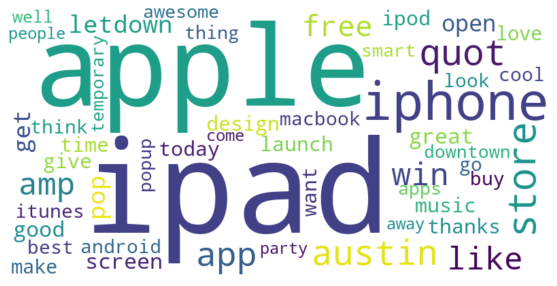

In [148]:
from wordcloud import WordCloud

# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative

In [163]:
df_combo_neg_sample.drop(columns=columns_to_drop, inplace=True)

In [164]:
# Defining X and y
X=df_combo_neg_sample["tweet_text"]
y=df_combo_neg_sample["emotion"]

In [165]:
sw = stopwords.words('english')

In [166]:
# Adding stopwords based on the dataset
sw.extend(["sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [167]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [168]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [169]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [170]:
token_tweets

['talk mistake building netflix iphone app',
 'think ipod touch gaming powerhouse average ipodtouch disappointed',
 'ipad disappointment expect apple flagship tablet ipad letdown',
 'nothing sillier watch people record video ipad',
 'try macbook heavy outdated worth investment macbook disappoint',
 'siri misunderstand feature bug siristruggles',
 'quot everyone already quot anti theft protection leave laptop ipad latte',
 'send waaaambulance ipad yes depress',
 'blackberry dell amp ipad feeling like dork geek conference make sense',
 'ipad week w ipad since give withdrawal',
 'try macbook feel like carry brick bulky outdated macbook disappoint',
 'apple obsession remove headphone jack frustrate everyone want wireless bringbackthejack appleheadphones',
 'try macbook heavy outdated worth investment macbook disappoint',
 'ipad thing addition place print cut b newsapps panel',
 'try macbook heavy outdated worth investment macbook disappoint',
 'try macbook heavy outdated worth investment m

In [171]:
cv=CountVectorizer()

In [172]:
X_vec_neg = cv.fit_transform(token_tweets)
X_vec_neg = pd.DataFrame.sparse.from_spmatrix(X_vec_neg)
X_vec_neg.columns = sorted(cv.vocabulary_)
X_vec_neg.set_index(y.index, inplace=True)

In [173]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [177]:
# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies = X_vec_neg.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(50)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
iphone            554
apple             531
ipad              497
disappoint        295
macbook           225


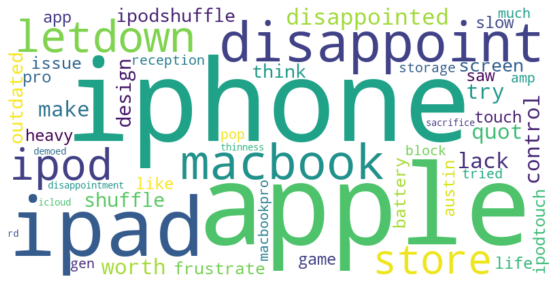

In [176]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Neutral

In [178]:
df_combo_neutral_sample.drop(columns=columns_to_drop, inplace=True)

In [179]:
# Defining X and y
X=df_combo_neutral_sample["tweet_text"]
y=df_combo_neutral_sample["emotion"]

In [180]:
# Adding stopwords based on the dataset
sw.extend(["sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [181]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [182]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [183]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X]

In [184]:
token_tweets

['ipad live unboxing front apple store video',
 'apple store downtown austin open til midnight',
 'iphone android',
 'apple open pop store austin geekfest apple apple brianlam ipad',
 'mashable ipad take video ipad gadget',
 'look iphone app manage multiple account allow select follow list suggestion',
 'apple customer service nightmare deal spend hour hold get resolution unhappy',
 'late game work iphone ipod hobo shotgun make w',
 'apple set temporary austin store serve horde ipad purchaser',
 'look around think apple tech company existence',
 'siri digital assistant hears want hear applesiristruggles',
 'content move back browser replicate work ipad u press button',
 'pick white ipad today apple store',
 'iphone blackberry amp android hootsuite app update hootsuite',
 'apple pop store everyone wait ipads first arrive degree badge everywhere',
 'totally make shift apple store downtown',
 'gabacustweets ipad sell go buyer report socialmedia brk',
 'beyond frustrate w samsung moment ru

In [185]:
cv=CountVectorizer()

In [186]:
X_vec_neutral = cv.fit_transform(token_tweets)
X_vec_neutral = pd.DataFrame.sparse.from_spmatrix(X_vec_neutral)
X_vec_neutral.columns = sorted(cv.vocabulary_)
X_vec_neutral.set_index(y.index, inplace=True)

In [187]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X]

In [188]:
# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies = X_vec_neutral.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(50)

# Print the most common words and their frequencies
print(most_common_words)

             Frequency
Word                  
apple              753
ipad               747
store              512
iphone             362
austin             244
pop                224
quot               191
open               190
app                156
amp                101
temporary           98
downtown            85
time                77
launch              75
design              68
popup               65
android             60
set                 60
tech                58
letdown             54
apps                54
ipod                51
shop                49
take                47
interface           46
rumor               43
get                 42
congress            41
mobile              40
sell                39
include             38
go                  37
classic             37
ipodclassic         37
wait                37
ubersocial          36
uberguide           36
check               35
video               35
come                35
first               34
game       

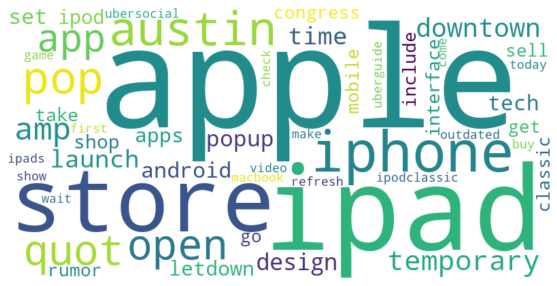

In [189]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Moving into pre processing

In [55]:
# Defining X and y
X=df_combo_sample["tweet_text"]
y=df_combo_sample["emotion"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state=42,
                                                    test_size=0.2)

In [57]:
sw = stopwords.words('english')

In [58]:
# Adding stopwords based on the dataset
sw.extend(["sxsw", "mention", "rt", "link", "new", "get", "line", "go", "use", "one", "via", "need", "would", "try", "come", "day", "give", "see", "know", "sxswi", "th", "even", "guy", "say"])

In [59]:
sw

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [60]:
def get_wordnet_pos(tweet_tag):
    '''
    We are converting nltk positional tags to wordnet tags
    '''
    if tweet_tag.startswith('J'):
        return wordnet.ADJ
    elif tweet_tag.startswith('V'):
        return wordnet.VERB
    elif tweet_tag.startswith('N'):
        return wordnet.NOUN
    elif tweet_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [61]:
def tweet_preparer(tweet, stop_words=sw):
    '''
    
    :param tweet: a tweet from the SXSW dataset 
    :return: a tweet string with words which have been 
            lemmatized, 
            parsed for stopwords, 
            made lowercase,
            and stripped of punctuation and numbers.
    '''
    
    regex_token = RegexpTokenizer(r"([a-zA-Z]+(?:’[a-z]+)?)") 
    tweet = regex_token.tokenize(tweet)
    tweet = [word.lower() for word in tweet]
    tweet = [word for word in tweet if word not in sw]
    # print(tweet)
    tweet = pos_tag(tweet)
    tweet = [(word[0], get_wordnet_pos(word[1])) for word in tweet]
    lemmatizer = WordNetLemmatizer() 
    tweet = [lemmatizer.lemmatize(word[0], word[1]) for word in tweet]
    return ' '.join(tweet)

In [62]:
token_tweets = [tweet_preparer(tweet, sw) for tweet in X_train]

In [63]:
token_tweets

['keyboard macbook keep malfunction know issue apple good quality control macbookproblems applekeyboard',
 'ipad acquire thanks perserverance vote husband year check',
 'justmet work apple year',
 'apple quot classiest fascist company america quot kara swisher',
 'charge talk sun iphone boom',
 'nfc chip big technology enablers nexus already iphone probably',
 'special apple store ipad block long',
 'blackout hotel true form shower light ipad',
 'funny xd funny xd rebecca black dionne warwick ipad',
 'thought path iphone photo app iphoneography mobilephotography',
 'apple set pop store austin sell bajillions ipad attendee brilliant',
 'donate apple allow donation itunes japanese earthquake victim',
 'try macbook heavy outdated worth investment macbook disappoint',
 'another hard call morning design ipad reading write genetic code go latter',
 'please u able attend buy ipad today consider save japan earthquake relief',
 'ipad also cartoonishly large digital camera cstejas',
 'icloud sto

#### chosing count vectorizer because we are less concerned about weighting words that are unique in the corpus.

In [64]:
X_train.head()

1148    "The keyboard on my MacBook keeps malfunctioning, and it's a known issue! Apple, do better quality control! #macbookproblems #applekeyboard"
7512                                                   Ipad 2 acquired thanks to @mention perserverance. 1 vote for husband of the year. Check #sxsw
1643                                                                                      #justmet @mention who worked for Apple for 25 years! #SXSW
7516                                                                 Apple...&quot;the classiest fascist company in America&quot; Kara Swisher #sxsw
2477                                                       Don't need to charge at #sxsw if you're talking in the sun with your iphone: {link} boom!
Name: tweet_text, dtype: object

In [65]:
#consider putting a pipleine here--

In [66]:
cv=CountVectorizer()

In [67]:
X_train_vec = cv.fit_transform(token_tweets)
X_train_vec = pd.DataFrame.sparse.from_spmatrix(X_train_vec)
X_train_vec.columns = sorted(cv.vocabulary_)
X_train_vec.set_index(y_train.index, inplace=True)

In [68]:
token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [69]:
X_test_vec = cv.transform(token_tweets_test)
X_test_vec = pd.DataFrame.sparse.from_spmatrix(X_test_vec)
X_test_vec.columns = sorted(cv.vocabulary_)
X_test_vec.set_index(y_test.index, inplace=True)

In [70]:
X_train_vec.head()

aapl  aaron  ab  abba  aber  ability  able  abnormal  absolutely  \
1148     0      0   0     0     0        0     0         0           0   
7512     0      0   0     0     0        0     0         0           0   
1643     0      0   0     0     0        0     0         0           0   
7516     0      0   0     0     0        0     0         0           0   
2477     0      0   0     0     0        0     0         0           0   

      absolutley  ...  zen  zero  zeus  zimride  zms  zombie  zomg  zone  \
1148           0  ...    0     0     0        0    0       0     0     0   
7512           0  ...    0     0     0        0    0       0     0     0   
1643           0  ...    0     0     0        0    0       0     0     0   
7516           0  ...    0     0     0        0    0       0     0     0   
2477           0  ...    0     0     0        0    0       0     0     0   

      zynga  zzzs  
1148      0     0  
7512      0     0  
1643      0     0  
7516      0     0  
2477      0     0  

[5 rows x 4638 columns]

In [71]:
mnb = MultinomialNB()

In [72]:
mnb.fit(X_train_vec, y_train)

MultinomialNB()

In [73]:
y_pred=mnb.predict(X_test_vec)

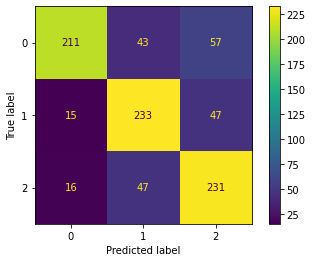

In [74]:
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(mnb, X_test_vec, y_test )

In [75]:
accuracy_score(y_test, y_pred)

0.75

In [76]:
precision_score(y_test, y_pred, average='weighted')

0.7629904142432088

In [77]:
recall_score(y_test, y_pred, average='weighted')

0.75

In [112]:
from collections import Counter
import pandas as pd

# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies = X_train_vec.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df = pd.DataFrame(word_frequencies, columns=['Frequency'])
word_frequencies_df.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df = word_frequencies_df.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words = word_frequencies_df.head(30)

# Print the most common words and their frequencies
print(most_common_words)

            Frequency
Word                 
ipad             1572
apple            1462
iphone           1105
store             696
quot              394
austin            377
app               301
pop               278
letdown           258
amp               235
disappoint        234
macbook           234
ipod              226
open              226
design            174
like              167
make              162
time              143
screen            139
temporary         131
get               129
launch            125
win               124
think             115
control           113
downtown          104
popup             103
lack              102
battery           101
outdated          100


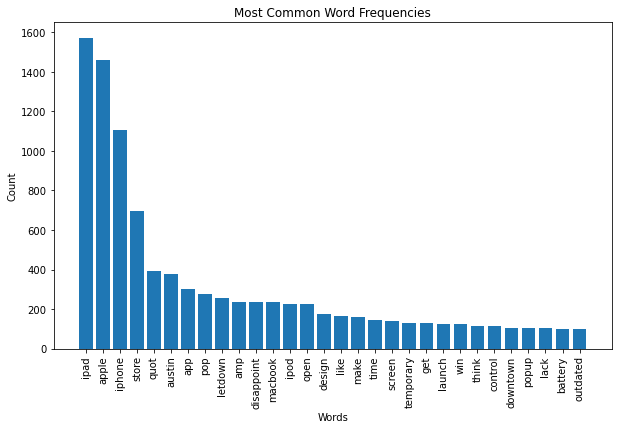

In [79]:
# Extract words and their counts from most_common_words DataFrame
most_common_words = word_frequencies_df.head(30)
words = most_common_words.index
counts = most_common_words['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Count')
plt.title('Most Common Word Frequencies')
plt.xticks(rotation=90)
plt.show()

In [80]:
#put the pip install for the cloud back here

In [81]:
#!pip install --upgrade pip

In [82]:
#!pip install --upgrade Pillow

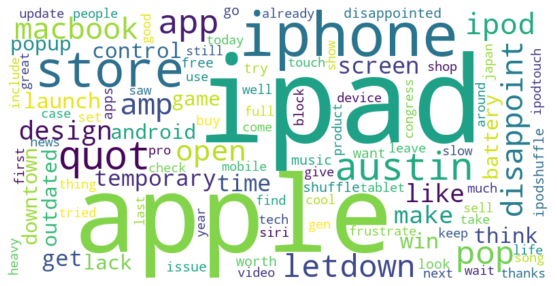

In [111]:
from wordcloud import WordCloud

# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

#### trying a TF-IDF vector instead of a count - just because. Need to change the name 'X_train_vec'? Use the same name with the count vectorizer?

In [84]:
tfidf = TfidfVectorizer()

In [85]:
X_train_vec_tfidf = tfidf.fit_transform(token_tweets)
X_train_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_train_vec_tfidf)
X_train_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_train_vec_tfidf.set_index(y_train.index, inplace=True)

In [86]:
# can delete this; created above
# token_tweets_test = [tweet_preparer(tweet, sw) for tweet in X_test]

In [87]:
X_test_vec_tfidf = tfidf.transform(token_tweets_test)
X_test_vec_tfidf = pd.DataFrame.sparse.from_spmatrix(X_test_vec_tfidf)
X_test_vec_tfidf.columns = sorted(tfidf.vocabulary_)
X_test_vec_tfidf.set_index(y_test.index, inplace=True)

In [88]:
X_train_vec_tfidf.head()

aapl  aaron   ab  abba  aber  ability  able  abnormal  absolutely  \
1148   0.0    0.0  0.0   0.0   0.0      0.0   0.0       0.0         0.0   
7512   0.0    0.0  0.0   0.0   0.0      0.0   0.0       0.0         0.0   
1643   0.0    0.0  0.0   0.0   0.0      0.0   0.0       0.0         0.0   
7516   0.0    0.0  0.0   0.0   0.0      0.0   0.0       0.0         0.0   
2477   0.0    0.0  0.0   0.0   0.0      0.0   0.0       0.0         0.0   

      absolutley  ...  zen  zero  zeus  zimride  zms  zombie  zomg  zone  \
1148         0.0  ...  0.0   0.0   0.0      0.0  0.0     0.0   0.0   0.0   
7512         0.0  ...  0.0   0.0   0.0      0.0  0.0     0.0   0.0   0.0   
1643         0.0  ...  0.0   0.0   0.0      0.0  0.0     0.0   0.0   0.0   
7516         0.0  ...  0.0   0.0   0.0      0.0  0.0     0.0   0.0   0.0   
2477         0.0  ...  0.0   0.0   0.0      0.0  0.0     0.0   0.0   0.0   

      zynga  zzzs  
1148    0.0   0.0  
7512    0.0   0.0  
1643    0.0   0.0  
7516    0.0   0.0  
2477    0.0   0.0  

[5 rows x 4638 columns]

In [89]:
mnb2 = MultinomialNB()

In [90]:
mnb2.fit(X_train_vec_tfidf, y_train)

MultinomialNB()

In [91]:
y_pred2=mnb2.predict(X_test_vec_tfidf)

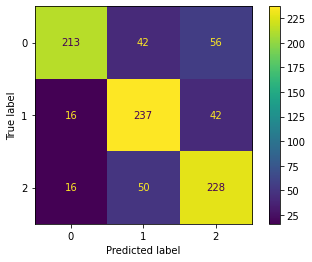

In [92]:
cm2 = confusion_matrix(y_test, y_pred2)
plot_confusion_matrix(mnb2, X_test_vec_tfidf, y_test );

In [93]:
# metrics here - accurary, precision, recall

In [94]:
accuracy_score(y_test, y_pred2)

0.7533333333333333

In [95]:
precision_score(y_test, y_pred2, average='weighted')

0.7650075805808552

In [96]:
recall_score(y_test, y_pred2, average='weighted')

0.7533333333333333

In [97]:
# Assuming X_train_vec is your vectorized dataset (e.g., using CountVectorizer)
word_frequencies_tfidf = X_train_vec_tfidf.sum(axis=0)

# Convert to DataFrame and transpose
word_frequencies_df2 = pd.DataFrame(word_frequencies_tfidf, columns=['Frequency'])
word_frequencies_df2.index.name = 'Word'

# Sort by frequency in descending order
word_frequencies_df2 = word_frequencies_df2.sort_values(by='Frequency', ascending=False)

# Get the most common words and their frequencies
most_common_words2 = word_frequencies_df2.head(30)

# Print the most common words and their frequencies
print(most_common_words2)

               Frequency
Word                    
ipad          197.345624
apple         193.722042
iphone        153.946353
store         139.938287
austin         86.850239
quot           79.147184
pop            75.384685
open           64.462061
app            62.241686
letdown        60.652846
macbook        57.094691
disappoint     56.350865
ipod           53.297130
amp            47.094310
temporary      44.850787
design         41.773845
launch         38.767603
make           38.108293
like           37.328422
win            36.657010
time           36.159120
downtown       36.102190
screen         35.746163
popup          33.472620
control        32.160051
get            32.127922
think          31.554775
outdated       30.612182
disappointed   29.334293
shuffle        28.755700


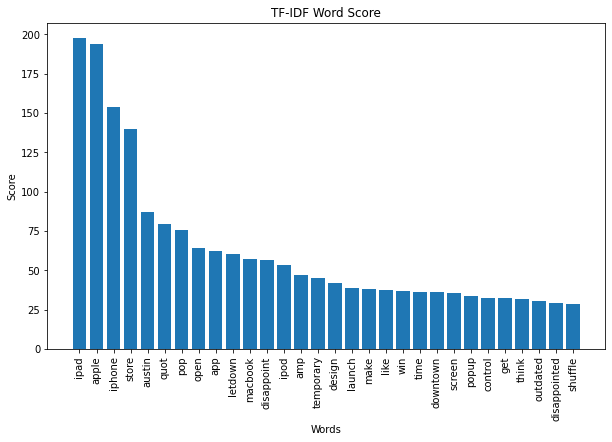

In [98]:
# Extract words and their counts from most_common_words DataFrame
most_common_words2= word_frequencies_df2.head(30)
words = most_common_words2.index
counts = most_common_words2['Frequency']

plt.figure(figsize=(10, 6))
plt.bar(range(len(words)), counts, tick_label=words)
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('TF-IDF Word Score')
plt.xticks(rotation=90)
plt.show()

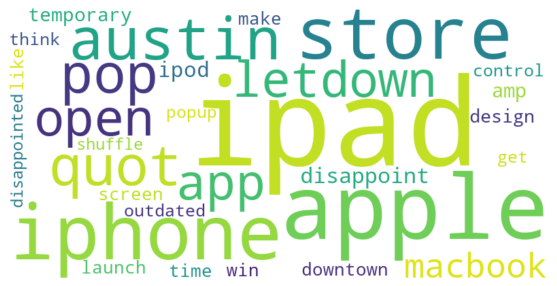

In [109]:
# Convert the most common words DataFrame to a dictionary
word_freq_dict = most_common_words2['Frequency'].to_dict()

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white', font_path=None).generate_from_frequencies(word_freq_dict)

# Display the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [99]:
grid = {'n_estimators': [500, 1000, 1500],
       'max_depth': [8, 10, 12, 14],
        'max_features': [3, 6, 9]
                }

In [100]:
rf_clf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 10, 12, 14],
                         'max_features': [3, 6, 9],
                         'n_estimators': [500, 1000, 1500]},
             scoring='accuracy')

In [101]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 6, 'n_estimators': 1500}

In [102]:
grid_search.best_score_

0.7419444444444444

In [103]:
rf = RandomForestClassifier(n_estimators=1500, max_features=6, max_depth=14)
rf.fit(X_train_vec, y_train)
y_pred = rf.predict(X_test_vec)
precision_score(y_test, y_pred, average="weighted")

0.7818158022269889

In [104]:
grid_search = GridSearchCV(estimator=rf_clf, param_grid=grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_vec_tfidf, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [8, 10, 12, 14],
                         'max_features': [3, 6, 9],
                         'n_estimators': [500, 1000, 1500]},
             scoring='accuracy')

In [105]:
grid_search.best_params_

{'max_depth': 14, 'max_features': 6, 'n_estimators': 1500}

In [106]:
grid_search.best_score_

0.736111111111111

In [107]:
rf = RandomForestClassifier(n_estimators=1500, max_features=6, max_depth=14)
rf.fit(X_train_vec_tfidf, y_train)
y_pred = rf.predict(X_test_vec_tfidf)
precision_score(y_test, y_pred2, average="weighted")

0.7650075805808552

In [108]:
#create frequency distribution, other possible visuals?

Monica's notes to self

- pipeline
- rf girdsearch
- freq distributions
- other vectorizer


- combine emotion_in_tweet_is_directed_at into two options (apple and google)
- drop row 6 - missing tweet (don't need to if just focusing on Apple)
- update is_there_an_emotion_directed_at_a_brand_or_product to numeric (0=neg, 1=neutral, 2=pos)
- consider adding SWSW to stop words 
- look at @, is it dropped in punctuation. do we want it dropped?
- look at #?

- used Vader, but it did not seem to classify well after spot checking
- explored using an API to pull down additional SXSW product data

- Additional notes: Sansung and Android included with Google
- do we want to delete google specific dataframe?


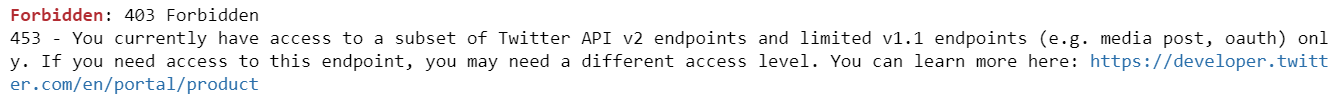
